In [34]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import array
from scipy.interpolate import griddata
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.optimize import root
import seaborn as sns
from statistics import mode

# Geospatial data manipulation and raster operations
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.warp import calculate_default_transform, reproject, Resampling
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

from shapely.geometry import Point

# Electromagnetic induction data inversion package
from emagpy import Problem

from PM import *
%matplotlib inline

In [35]:
# 0.3: Get dataset location
# -------------------------
# store dataset URL's as string variables
FDEM_surveydata = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/survey_Lam72.csv'
FDEM_transect = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
samples = 'C:/Users/gmendoza/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/samples_combined.csv'
#FDEM_surveydata = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/survey_042022/survey_Lam72.csv'
#FDEM_transect = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Code_EM_survey_case/ERT_PH_set.csv'
#samples = 'C:/Users/mendo/OneDrive - UGent/Documentos/PhD/EM case survey/Data/Proefhoeve/samples_combined.csv'

# URL for grid masking file
blank_json = 'https://users.ugent.be/~pjdsmedt/ESS2023/blank.json'

# Create dataframes from datasets
'''
Import datasets as dataframes
-----------------------------
    - df = dataframe with the full FDEM dataset
    - dt = dataframe with the FDEM transect
    - ds = datasframe with the sample data (including analytical data)
    - blank = geojson (polygon) outlining survey extent
'''
df = pd.read_csv(FDEM_surveydata, sep=',', header=0)
dt = pd.read_csv(FDEM_transect, sep=',', header=0, encoding='cp1252')
ds = pd.read_csv(samples, sep=',', header=0, encoding='cp1252')
blank_in = gpd.read_file(blank_json)
blank = blank_in.to_crs('EPSG:31370')
ds.columns

Index(['Unnamed: 0', 'x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'HCP0.5_inph', 'PRP0.6_inph',
       'HCP1.0_inph', 'PRP1.1_inph', 'HCP2.0_inph', 'PRP2.1_inph', 'name',
       'depth', 'x_clhs', 'y_clhs', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
       'TOC', 'humus', 'bd', 'vwc', 'copeky', 'temp', 'rperm', 'iperm'],
      dtype='object')

## Preprocesingn

In [36]:
ds_c = ds.copy()
# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds_c['bulk_ec_hp'] = logsdon(50e6, ds_c.rperm, ds_c.iperm)

# Caclculate Bulk EC from HydraProbe data at 0 Hz
def objective_func_ec_dc(bulk_ec_dc, frequency_ec, bulk_ec):
    return (LongmireSmithEC(bulk_ec_dc, frequency_ec) - bulk_ec)**2
bulk_ec_dc_hp = []

for i in range(len(ds_c.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(50e6, ds_c.bulk_ec_hp[i]), bounds=[(0, 1)])
    bulk_ec_dc_hp.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_c['bulk_ec_dc_hp'] = bulk_ec_dc_hp

# Caclculate Water EC from HydraProbe data at 50Mhz
ds_c['water_ec_hp'] = Hilhorst(ds_c.bulk_ec_hp, ds_c.rperm, water_perm, offset)
ds_c['iperm_water'] = ds_c.water_ec_hp/(50e6*2*pi*epsilon_0)

# Caclculate Aparent Bulk EC from EMI at 0 Hz in S/m
EC_columns = ['HCP0.5', 'PRP0.6', 'HCP1.0', 'PRP1.1', 'HCP2.0', 'PRP2.1'] 
for col in EC_columns:
    EC_DC = []
    for i in range(len(ds_c[col].values)):
        res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_c[col][i]/1000), bounds=[(0, 1)])
        EC_DC.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

    ds_c[col+'_DC'] = EC_DC

In [37]:
R2_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2', 'Best EC feature 10cm', 'R2 10cm', 
                                      'Best EC feature 50cm', 'R2 50cm', 'Best EC feature layered', 'R2 layered'],
                  index=range(0, 5))

RMSE_stochastic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE', 'Best EC feature layered', 'RMSE layered'],
                  index=range(0, 5))

R2_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature', 'R2'],
                  index=range(0, 5))

RMSE_deterministic = pd.DataFrame(columns=['Target', 'Best EC feature', 'RMSE'],
                  index=range(0, 5))

## Inversion of DC EMI data

100%|██████████| 30/30 [00:00<00:00, 214.30it/s]


   Finished inversion


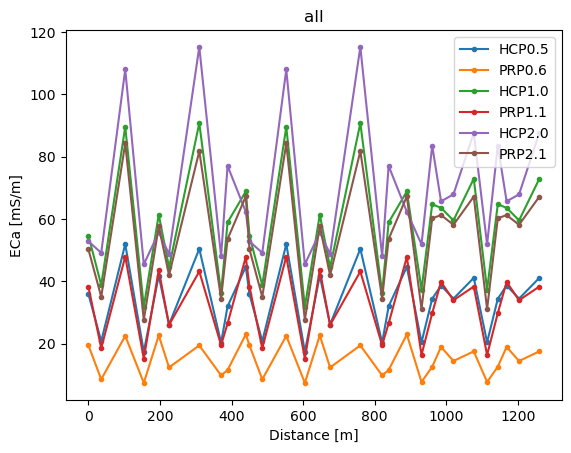

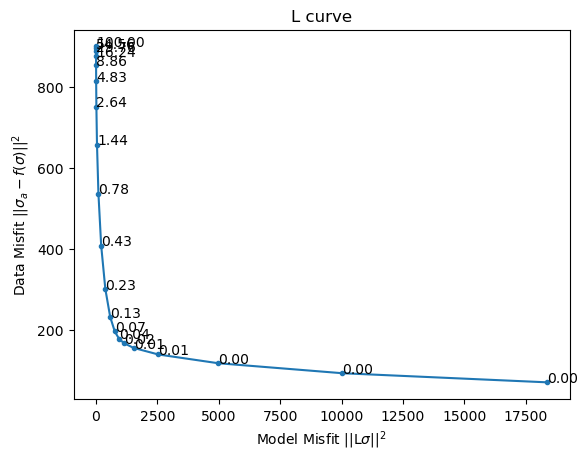

In [38]:
#depths_in = [0.1, 0.5, 0.8, 1.5]
depths_in = [0.4, 0.8]

# Set pdf name for exporting plot
pdf_name = 'Modelled_EC_profiles.pdf'

# ******************************************************************** #
# Create an inversion problem object to solve with EMagPy

sampling_path = samples
sample_transect = Problem()
sample_transect.createSurvey(sampling_path, freq=9e3,hx=0.165,unit='ECa')
sample_transect.setInit(depths0=depths_in)
sample_transect.show()
sample_transect.lcurve()

# Run the inversion
sample_transect.invert( alpha=0.03, njobs=-1) # FSIQ, alpha  check forwardModel='FSeq',
print('   Finished inversion')

# ----------------------------------------------------------------------
# Plotting and exporting the EC profiles figure as a pdf
# ----------------------------------------------------------------------

# Putting the results in a dataframe, and concatenate with analytical data.
depth_values = sample_transect.depths[0][0]
layer_cols = ['EC_{:.2f}'.format(d) for d in depth_values] + ['EC_end']
data = np.c_[sample_transect.surveys[0].df[['x', 'y']].values, 
             sample_transect.models[0]]

ds_inv = pd.DataFrame(data, columns=['x', 'y'] + layer_cols)
selected_columns_ds = pd.concat([ds_c.iloc[:, 3:11], ds_c.iloc[:, 17:]], axis=1)

ds_all = pd.concat([ds_inv, selected_columns_ds], axis=1)
#ds_all = ds_all.dropna()

unique_sample_ids = ds_all['name'].unique()

# Calculate number of rows and columns for the subplot
subplot_rows = 3
subplot_cols = 5

# Get axis limits
global_x_min = ds_all[layer_cols].min().min()
global_x_max = ds_all[layer_cols].max().max()

csv_filename = 'inverted_samples_PH.csv'
ds_all.to_csv(csv_filename)

## 

In [39]:
# Calculate the Bulk EC DC inverted at suitable depth based on invertion layers.
bulk_ec_dc_010 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.40'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_010.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_010'] = bulk_ec_dc_010
ds_all_10cm = ds_all.loc[ds_all['depth']==10].reset_index(drop=True)

bulk_ec_dc_050 = []
for i in range(len(ds_all.bulk_ec_hp.values)):
    res = minimize(objective_func_ec_dc, 0.05, args=(9e3, ds_all['EC_0.80'][i]/1000), bounds=[(0, 1)])
    bulk_ec_dc_050.append(np.nan if np.isnan(res.fun) else round(res.x[0], 5) )

ds_all['bulk_ec_dc_050'] = bulk_ec_dc_050
ds_all_50cm = ds_all.loc[ds_all['depth']==50].reset_index(drop=True)

ds_all['bulk_ec_dc_inv'] = [ds_all.bulk_ec_dc_010[i] if ds_all.depth[i] == 10 else ds_all.bulk_ec_dc_050[i] for i in range(len(ds_all.vwc))]

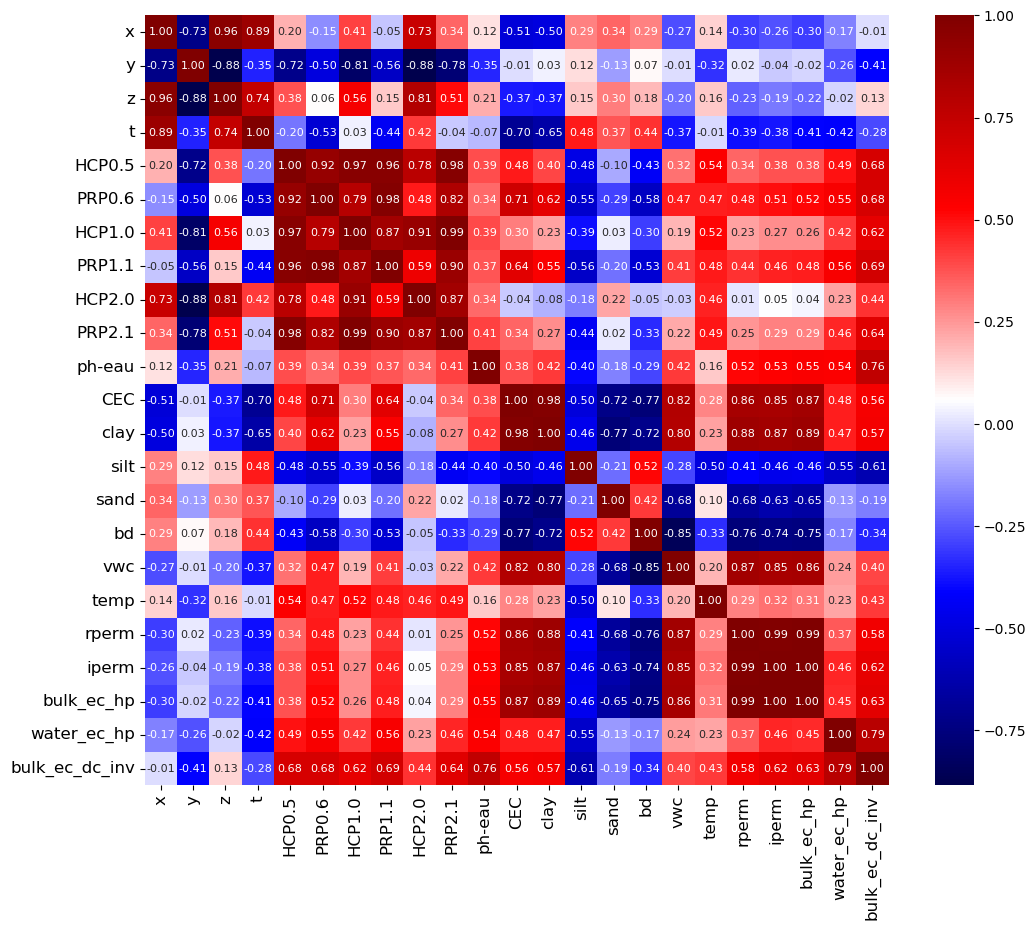

In [40]:
ds_f = ds_all[['x', 'y', 'z', 't', 'HCP0.5', 'PRP0.6', 'HCP1.0',
       'PRP1.1', 'HCP2.0', 'PRP2.1', 'ph-eau', 'CEC', 'clay', 'silt', 'sand',
        'bd', 'vwc', 'temp', 'rperm', 'iperm', 'bulk_ec_hp', 'water_ec_hp', 'bulk_ec_dc_inv']]

# Setting the figure size
plt.figure(figsize=(12, 10))

# Plotting correlation heatmap with annotations
dataplot = sns.heatmap(ds_f.corr(), cmap="seismic", annot=True, fmt=".2f", annot_kws={"size": 8})

dataplot.tick_params(axis='both', which='major', labelsize=12)

# Rotating y-axis labels for better visualization
dataplot.set_yticklabels(dataplot.get_yticklabels(), rotation=0)

# Setting the label size for x and y axes
dataplot.set_xlabel(dataplot.get_xlabel(), fontsize=14)
dataplot.set_ylabel(dataplot.get_ylabel(), fontsize=14)

plt.show()

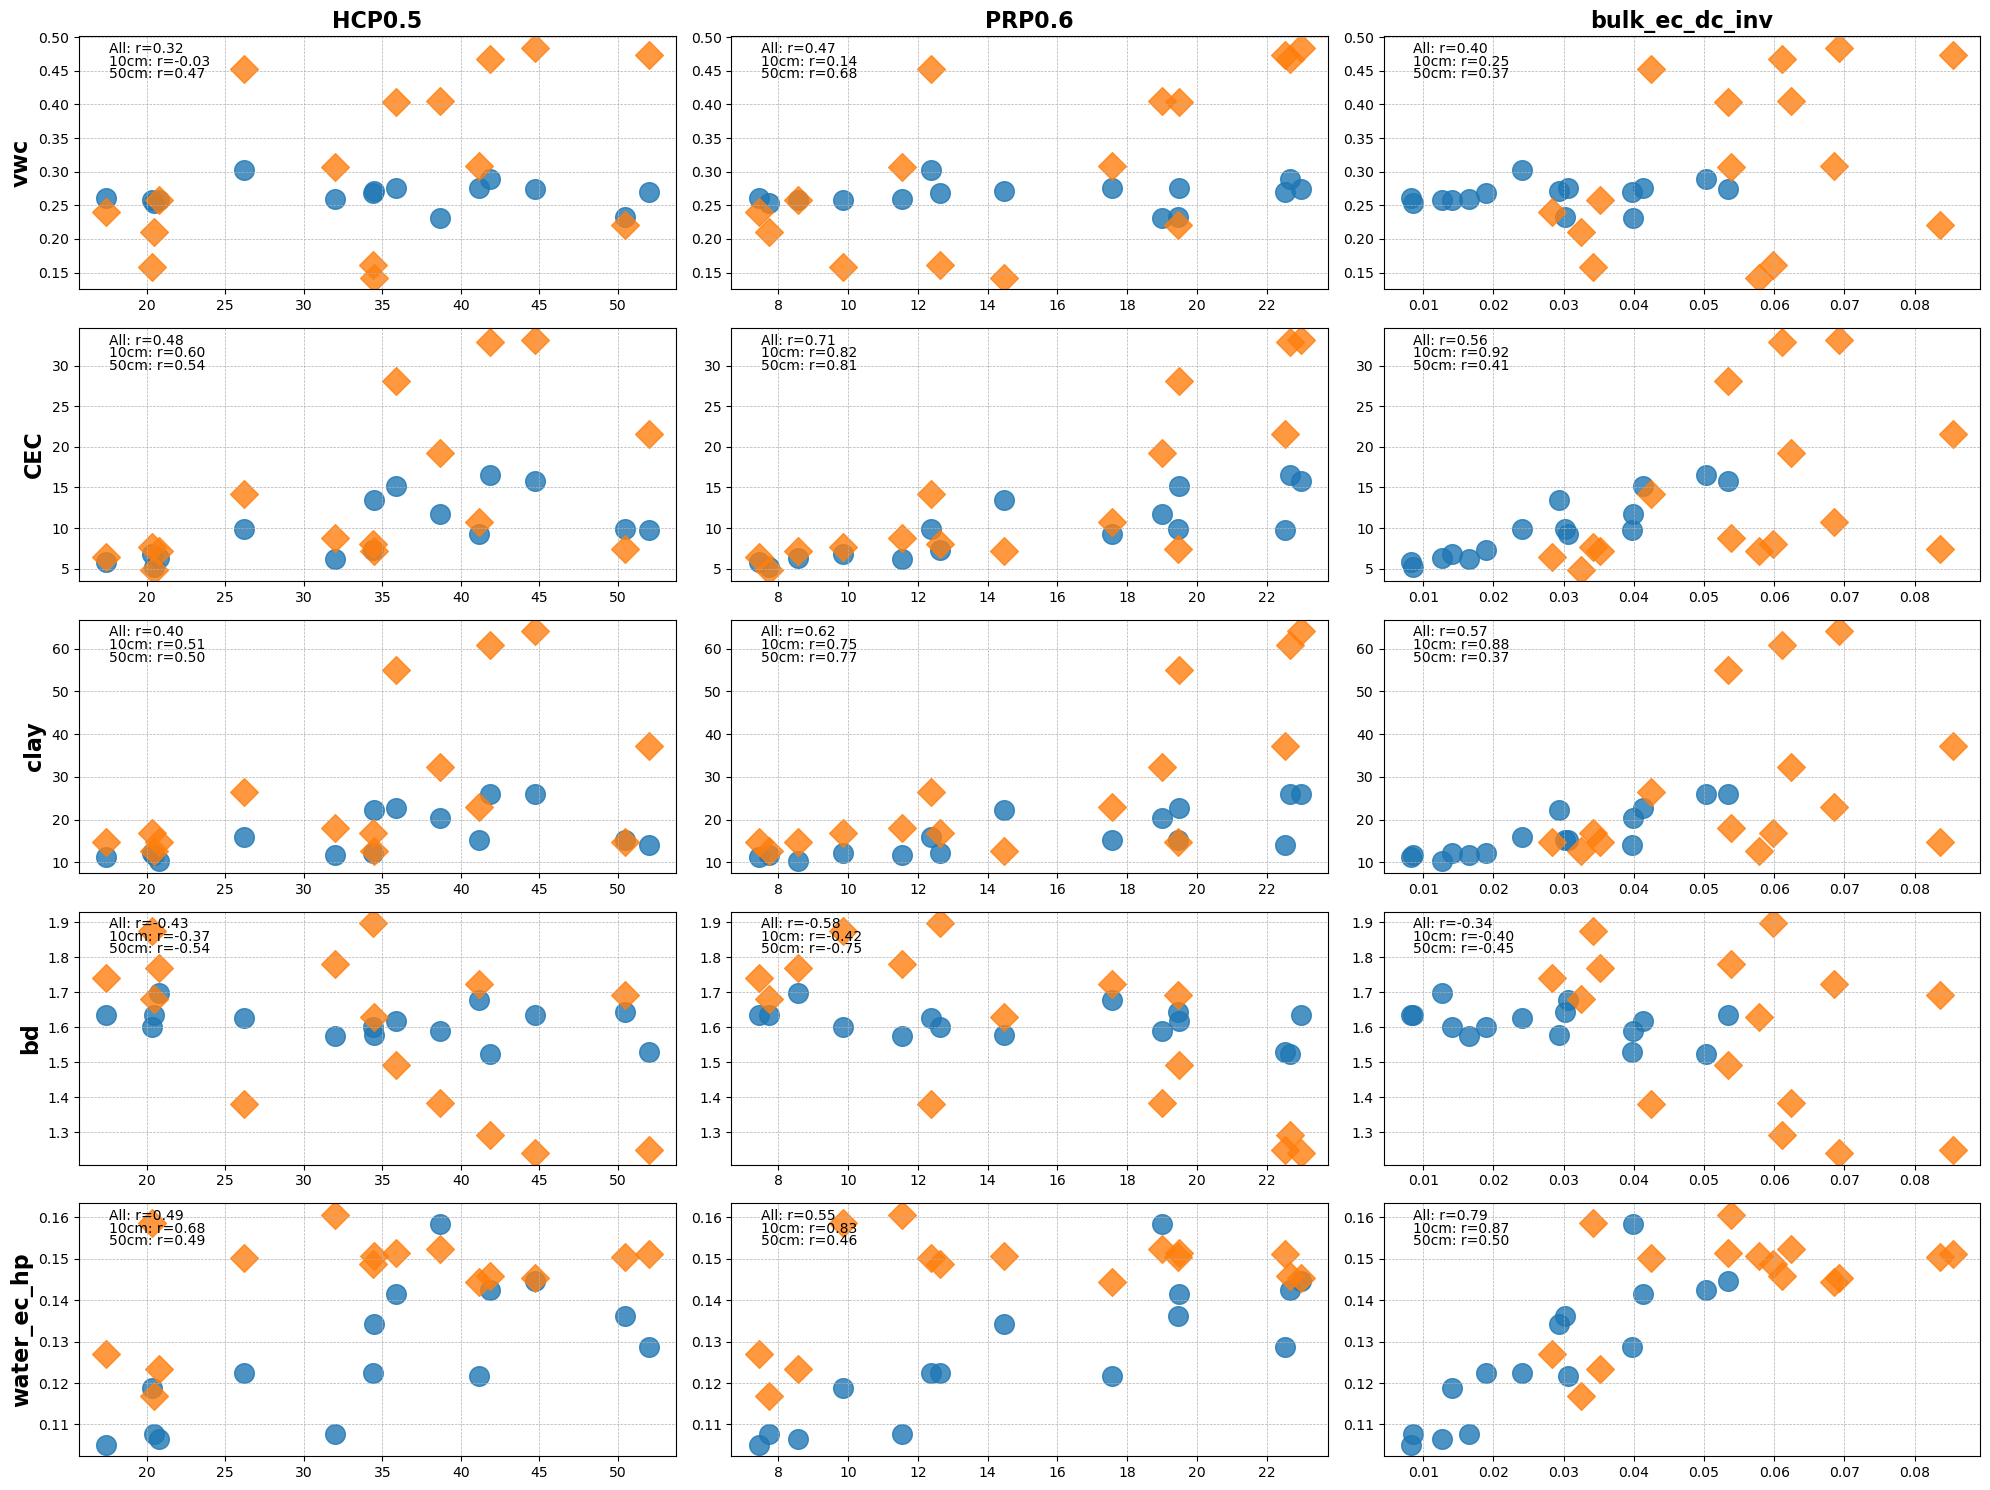

In [41]:
fig, axes = plt.subplots(5, 3, figsize=(20, 15))
ss = 200

targets = ['vwc', 'CEC', 'clay', 'bd', 'water_ec_hp']
preds = ['HCP0.5', 'PRP0.6', 'bulk_ec_dc_inv']

def corr_plot(df, preds, targets):

    for target_index, target in enumerate(targets):
        for pred_index, pred in enumerate(preds):

            ax = axes[target_index, pred_index]  # select the individual subplot based on their indices
            
            # Add grid to the subplot
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # General correlation coefficient
            general_corr = np.corrcoef(df[pred].dropna(), df[target].dropna())[0, 1]
            ax.text(0.05, 0.95, f'All: r={general_corr:.2f}', transform=ax.transAxes, va="center")

            for layer_cm in [10, 50]:
                x_data = df[df['depth'] == layer_cm][pred]
                y_data = df[df['depth'] == layer_cm][target]
                
                # Calculate correlation coefficient for the specific depth
                corr = np.corrcoef(x_data.dropna(), y_data.dropna())[0, 1]

                if layer_cm == 10:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='o')
                    ax.text(0.05, 0.9, f'10cm: r={corr:.2f}', transform=ax.transAxes, va="center")
                if layer_cm == 50:
                    ax.scatter(x_data, y_data, s=ss, alpha=0.8, marker='D')
                    ax.text(0.05, 0.85, f'50cm: r={corr:.2f}', transform=ax.transAxes, va="center")

            # Set titles for columns
            if target_index == 0:  # only for the first row
                ax.set_title(pred, fontweight='bold', fontsize=16)
                
            # Set row labels for the leftmost plots
            if pred_index == 0:  # only for the first column
                ax.set_ylabel(target, fontweight='bold', fontsize=16)

corr_plot(ds_all, preds, targets)
plt.tight_layout()  # for better spacing

## Deterministic modelling

In [42]:
clay_50cm = np.mean(ds_all.clay[ds_all['depth']==50])
clay_10cm = np.mean(ds_all.clay[ds_all['depth']==10])
bd_50cm = np.mean(ds_all.bd[ds_all['depth']==50])
bd_10cm = np.mean(ds_all.bd[ds_all['depth']==10])
water_ec_hp_50cm = np.mean(ds_all.water_ec_hp[ds_all['depth']==50])
water_ec_hp_10cm = np.mean(ds_all.water_ec_hp[ds_all['depth']==10])

# Defining minimization function to obtain water using Fu
def objective_func_wat(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec, EC):
    return (Fu(x, clay, bulk_density, particle_density, water_ec, solid_ec, dry_ec, sat_ec) - EC)**2

def calculate_water(ds, col, round_n=3):
    wat = []
    for dc in ds[col]:
        index = ds.index[ds[col] == dc][0]
        if ds.depth[index] == 50:
            res = minimize(objective_func_wat, 0.15, args=(clay_50cm, bd_50cm, 2.65, water_ec_hp_50cm, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])
        else:
            res = minimize(objective_func_wat, 0.15, args=(clay_10cm, bd_10cm, 2.65, water_ec_hp_10cm, 
                                                       0, np.nan, np.nan, dc), bounds=[(0, .65)])            
        wat.append(np.nan if np.isnan(res.fun) else round(res.x[0], round_n))

    r2_val = round(r2_score(ds.vwc.values, wat), round_n)
    rmse_val = round(RMSE(ds.vwc.values, wat), round_n)
    return wat, r2_val, rmse_val


def plot_results(df, actual, predicted, r2_val, rmse_val, scale, title):
    
    fig, axes = plt.subplots(figsize=[7, 6])
    ss = 200
    
    # Create a colormap
    cmap = plt.cm.Reds

    # Loop through each point and plot with appropriate marker
    for i, (x, y, s) in enumerate(zip(actual, predicted, scale)):
        if ~(np.isnan(x) or np.isnan(y) or np.isnan(s)):
            if df['depth'].iloc[i] == 50:
                marker_style = 'D'
            else:
                marker_style = 'o'
            axes.scatter(x, y, s=ss, alpha=0.8, c=[s], cmap=cmap, vmin=0, vmax=65, marker=marker_style)

    # Create a dummy scatter plot to use its colormap
    dummy_scatter = plt.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=65)
    cbar = plt.colorbar(dummy_scatter, ax=axes)

    axes.plot([0, 0.6], [0, 0.6], color='black', label=f'R2 = {r2_val}; RMSE = {rmse_val}')
    axes.set_xlabel("Observed wat")
    axes.set_ylabel("Predicted wat")
    axes.set_title(title)
    axes.legend()
    axes.grid(True)
    axes.set_xlim([0, 0.6])
    axes.set_ylim([0, 0.6])
    plt.show()

for predicting water deterministically, the best predictor is:HCP0.5_DC


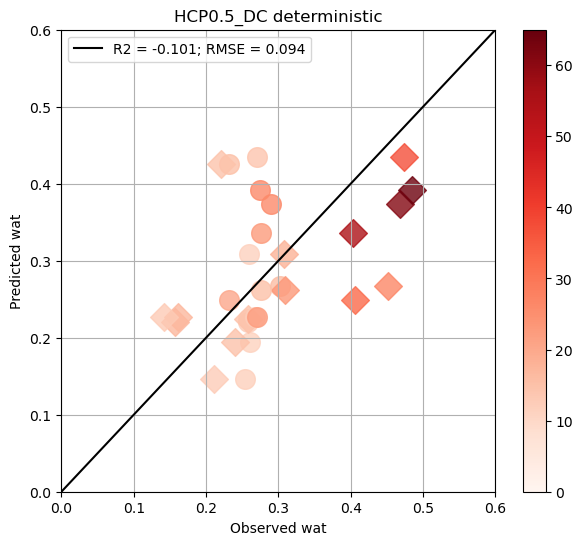

for predicting water deterministically, the best predictor is:HCP0.5_DC


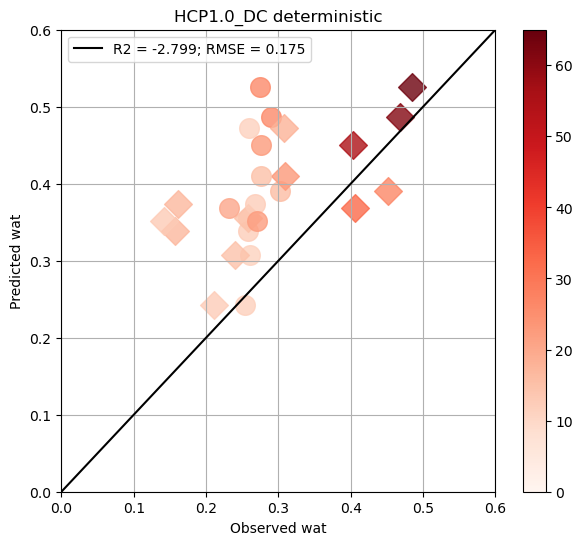

for predicting water deterministically, the best predictor is:HCP0.5_DC


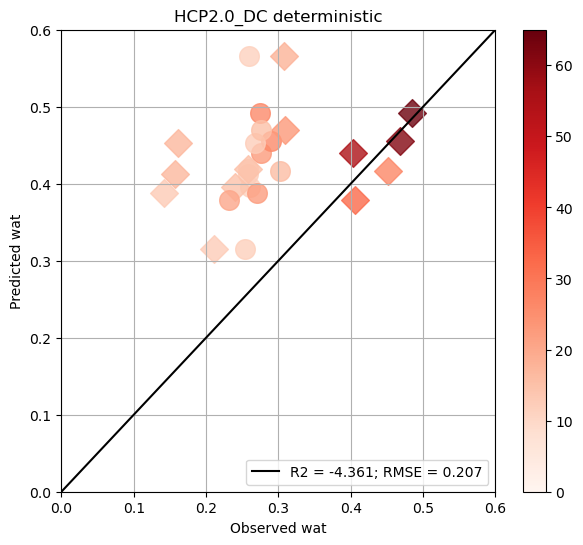

for predicting water deterministically, the best predictor is:HCP0.5_DC


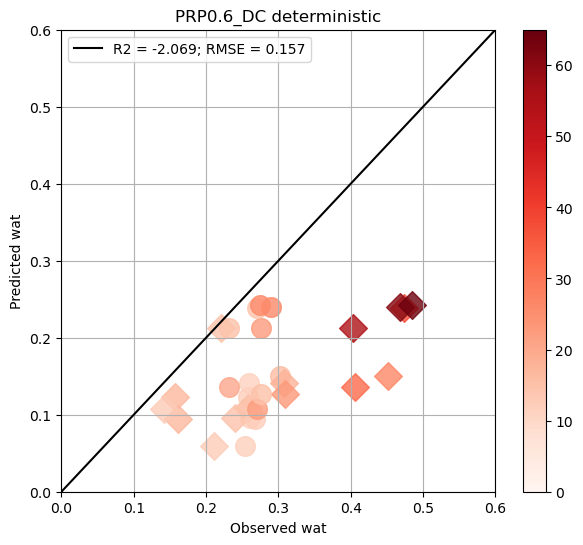

for predicting water deterministically, the best predictor is:PRP1.1_DC


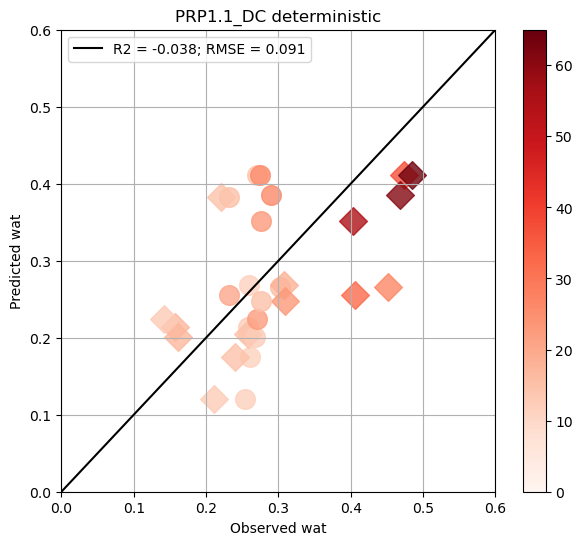

for predicting water deterministically, the best predictor is:PRP1.1_DC


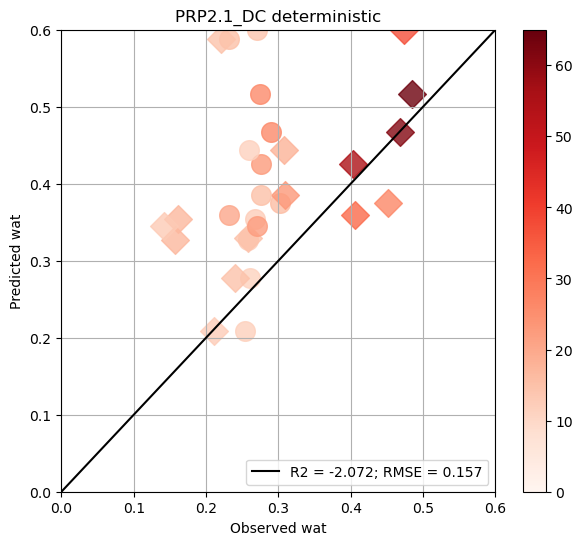

for predicting water deterministically, the best predictor is:PRP1.1_DC


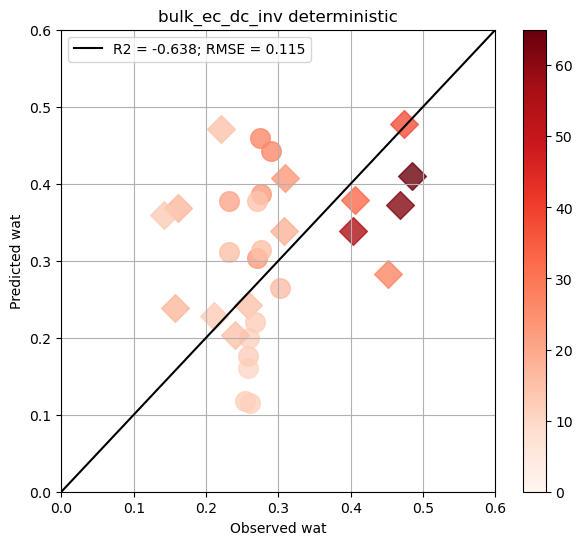

,Target,Best EC feature,R2
0,vwc,PRP1.1_DC,-0.038
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN


In [43]:
feature_set = [
    ['HCP0.5_DC'],
    ['HCP1.0_DC'],
    ['HCP2.0_DC'],
    ['PRP0.6_DC'],
    ['PRP1.1_DC'],
    ['PRP2.1_DC'],
    ['bulk_ec_dc_inv']
]

target = ds_all['vwc']
R2_, RMSE_, WAT_ = [], [], []

i = 0
for feature in feature_set:
    title = feature[0]+' deterministic'
    wat, r2, rmse = calculate_water(ds_all, feature[0])
    R2_.append(r2)
    RMSE_.append(rmse)
    WAT_.append(wat)

    best_index = R2_.index(np.max(R2_))

    R2_deterministic['R2'][0] = R2_[best_index]
    RMSE_deterministic['RMSE'][0] = RMSE_[best_index]
    R2_deterministic['Best EC feature'][0] = feature_set[best_index][0]
    RMSE_deterministic['Best EC feature'][0] = feature_set[best_index][0]
    R2_deterministic['Target'][0] = 'vwc'
    RMSE_deterministic['Target'][0] = 'vwc'

    print('for predicting water deterministically, the best predictor is:' +feature_set[best_index][0])

    plot_results(ds_all, target, wat, r2, rmse, ds_all.clay, title)

R2_deterministic

## Stochastic modelling

In [44]:
feature_sets = [
    ['HCP0.5'],
    ['HCP1.0'],
    ['HCP2.0'],
    ['HCP0.5', 'HCP1.0'],
    ['HCP0.5', 'HCP2.0'],
    ['HCP1.0', 'HCP2.0'],
#    ['HCP0.5', 'HCP1.0', 'HCP2.0'],
    ['PRP0.6'],
    ['PRP1.1'],
    ['PRP2.1'],
    ['PRP0.6', 'PRP1.1'],
    ['PRP0.6', 'PRP2.1'],
    ['PRP1.1', 'PRP2.1'],
#    ['PRP0.6', 'PRP1.1', 'PRP2.1'], 
    ['PRP0.6', 'HCP0.5'],
    ['bulk_ec_dc_inv'],
#    ['bulk_ec_dc_inv', 'PRP0.6', 'HCP0.5']
]

In [45]:
def bars_plot(feature_sets, test_errors_summary, train_errors_summary, title):
    fig, ax = plt.subplots()
    width = 0.35  # the width of the bars

    x = np.arange(len(feature_sets))
    rects1 = ax.bar(x - width/2, test_errors_summary, width, color = 'red', label='Test')
    rects2 = ax.bar(x + width/2, train_errors_summary, width, color = 'blue', label='Train')

    ax.axhline(0, color='grey', linewidth=0.8)
    ax.set_ylabel('Scores '+title[0])
    ax.set_xticks(range(len(test_errors_summary)), feature_sets, rotation = 90)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.set_title('features vs '+title[0])
    fig.tight_layout()

    plt.show()
    plt.savefig("stochastic_"+title[0], dpi=200)

In [46]:
def stochastic_poly(df, feature_columns, Y, n=4, iters=100, round_n=3):
    ypred_train_best, ypred_test_best, R2_train_t_best, R2_test_t_best, RMSE_train_t_best, RMSE_test_t_best = [], [], [], [], [], []
    X = df[feature_columns[0]].values.reshape(-1, 1)
    
    for i in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=i)
        LinReg = LinearRegression()
        ypred_train_, ypred_test_, R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], [], [], []

        for k in range(n):
            poly = PolynomialFeatures(degree=k)
            poly.fit(X_train)
            Xt_train = poly.transform(X_train)
            Xt_test = poly.transform(X_test)

            LinReg.fit(Xt_train, y_train)
            ypred_train = LinReg.predict(Xt_train)
            ypred_test = LinReg.predict(Xt_test)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            ypred_train_.append(ypred_train)
            ypred_test_.append(ypred_test)
            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        ypred_train_best.append(ypred_train_)
        ypred_test_best.append(ypred_test_)
        R2_train_t_best.append(R2_train_t_)
        R2_test_t_best.append(R2_test_t_)
        RMSE_train_t_best.append(RMSE_train_t_)
        RMSE_test_t_best.append(RMSE_test_t_)

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_best]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_best]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_best]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_best]
    
    RMSE_sums = [np.sum(RMSE_test_n1), np.sum(RMSE_test_n2), np.sum(RMSE_test_n3), np.sum(RMSE_test_n4)]
    best_n = RMSE_sums.index(np.min(RMSE_sums))
    return best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_best]), round_n)                                             

i 0
for predicting stochastically vwc the best predictor is:bulk_ec_dc_inv


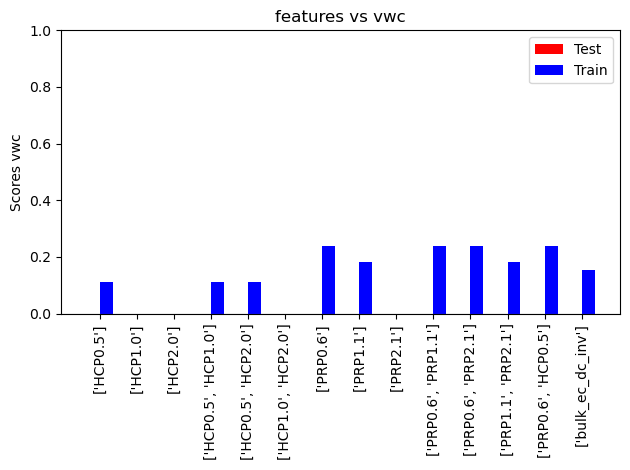

i 1
for predicting stochastically CEC the best predictor is:PRP0.6


<Figure size 640x480 with 0 Axes>

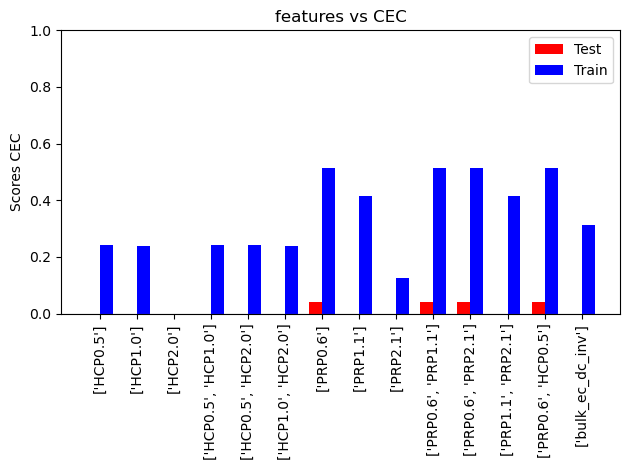

i 2
for predicting stochastically clay the best predictor is:bulk_ec_dc_inv


<Figure size 640x480 with 0 Axes>

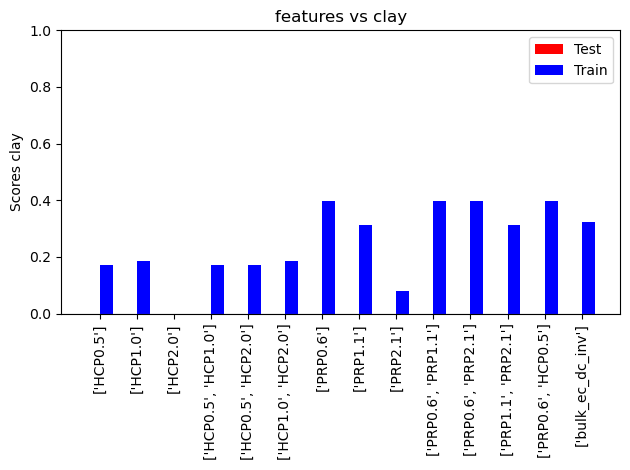

i 3
for predicting stochastically bd the best predictor is:PRP0.6


<Figure size 640x480 with 0 Axes>

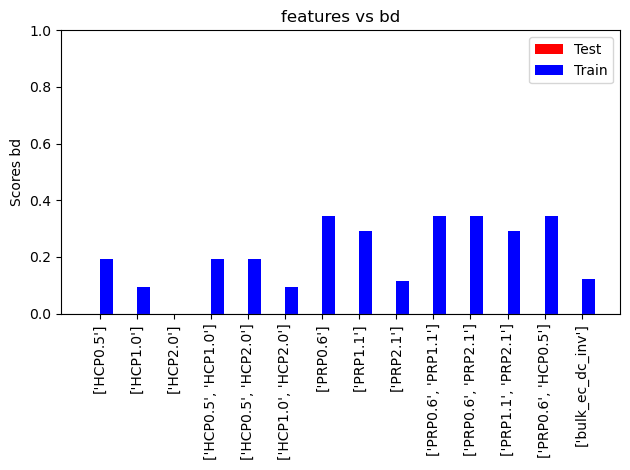

i 4
for predicting stochastically water_ec_hp the best predictor is:bulk_ec_dc_inv


<Figure size 640x480 with 0 Axes>

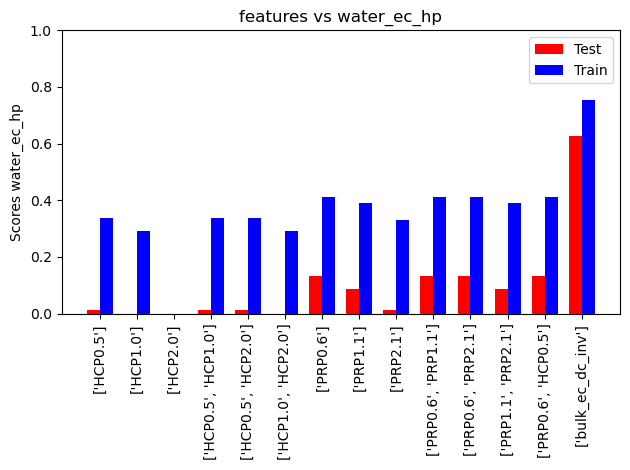

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature layered,R2 layered
0,vwc,bulk_ec_dc_inv,-0.06,NaN,NaN,NaN,NaN,NaN,NaN
1,CEC,PRP0.6,0.039,NaN,NaN,NaN,NaN,NaN,NaN
2,clay,bulk_ec_dc_inv,-0.094,NaN,NaN,NaN,NaN,NaN,NaN
3,bd,PRP0.6,-0.012,NaN,NaN,NaN,NaN,NaN,NaN
4,water_ec_hp,bulk_ec_dc_inv,0.627,NaN,NaN,NaN,NaN,NaN,NaN


<Figure size 640x480 with 0 Axes>

In [47]:
target_set = [
    ['vwc'],
    ['CEC'],
    ['clay'],
    ['bd'],
    ['water_ec_hp']
]

i = 0
for t in target_set:
    print('i', i)
    R2_test, R2_train = [], []
    target = ds_all[t[0]].values
    
    for feature_set in feature_sets:        
        best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly(ds_all, feature_set, target, iters=100)
        #print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set)
        R2_test.append(R2_test_pol)
        R2_train.append(R2_train_pol)

    best_index = R2_test.index(np.max(R2_test))
    R2_stochastic['Best EC feature'][i] = feature_sets[best_index][0]
    R2_stochastic['Target'][i] = t[0]
    R2_stochastic['R2'][i] = R2_test[best_index]
    print('for predicting stochastically '+ t[0]+' the best predictor is:' +feature_sets[best_index][0])
    bars_plot(feature_sets, R2_test, R2_train, t)
    i+=1
R2_stochastic

## Layered stochastic modelling

In [48]:
def stochastic_poly_layer(df, feature_columns, target, layer_cm, n=4, iters=100, round_n=3):
    ypred_train_best, ypred_test_best, R2_train_t_best, R2_test_t_best, RMSE_train_t_best, RMSE_test_t_best = [], [], [], [], [], []

    for i in range(iters):
        X_layer_cm = df[df['depth'] == layer_cm][feature_columns[0]].values.reshape(-1, 1)
        Y_layer_cm = df[df['depth'] == layer_cm][target[0]].values

        X_train, X_test, y_train, y_test = train_test_split(X_layer_cm, Y_layer_cm, test_size=0.3, random_state=i)
        LinReg = LinearRegression()
        ypred_train_, ypred_test_, R2_train_t_, R2_test_t_, RMSE_train_t_, RMSE_test_t_ = [], [], [], [], [], []

        for k in range(n):
            poly = PolynomialFeatures(degree=k)
            poly.fit(X_train)
            Xt_train = poly.transform(X_train)
            Xt_test = poly.transform(X_test)

            LinReg.fit(Xt_train, y_train)
            ypred_train = LinReg.predict(Xt_train)
            ypred_test = LinReg.predict(Xt_test)

            R2_train_t = r2_score(y_train, ypred_train)
            R2_test_t = r2_score(y_test, ypred_test)
            RMSE_train_t = RMSE(y_train, ypred_train)
            RMSE_test_t = RMSE(y_test, ypred_test)

            ypred_train_.append(ypred_train)
            ypred_test_.append(ypred_test)
            R2_train_t_.append(R2_train_t)
            R2_test_t_.append(R2_test_t)
            RMSE_train_t_.append(RMSE_train_t)
            RMSE_test_t_.append(RMSE_test_t)

        ypred_train_best.append(ypred_train_)
        ypred_test_best.append(ypred_test_)
        R2_train_t_best.append(R2_train_t_)
        R2_test_t_best.append(R2_test_t_)
        RMSE_train_t_best.append(RMSE_train_t_)
        RMSE_test_t_best.append(RMSE_test_t_)

    RMSE_test_n1 = [inner_list[0] for inner_list in RMSE_test_t_best]
    RMSE_test_n2 = [inner_list[1] for inner_list in RMSE_test_t_best]
    RMSE_test_n3 = [inner_list[2] for inner_list in RMSE_test_t_best]
    RMSE_test_n4 = [inner_list[3] for inner_list in RMSE_test_t_best]
    
    RMSE_sums = [np.sum(RMSE_test_n1), np.sum(RMSE_test_n2), np.sum(RMSE_test_n3), np.sum(RMSE_test_n4)]
    best_n = RMSE_sums.index(np.min(RMSE_sums))
    return best_n, round(np.mean([inner_list[best_n] for inner_list in R2_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in R2_train_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_test_t_best]), round_n), round(np.mean([inner_list[best_n] for inner_list in RMSE_train_t_best]), round_n)                                             

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['HCP0.5'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['HCP1.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['HCP2.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['HCP0.5', 'HCP1.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['HCP0.5', 'HCP2.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['HCP1.0', 'HCP2.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.525 0.0 0.02 0.017 ['PRP0.6'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train

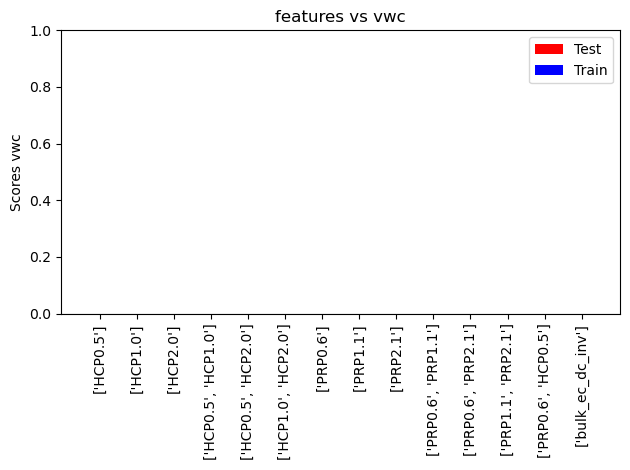

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -1.014 0.387 3.529 2.845 ['HCP0.5'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.371 0.44 3.716 2.703 ['HCP1.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -1.271 0.0 3.844 3.671 ['HCP2.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -1.014 0.387 3.529 2.845 ['HCP0.5', 'HCP1.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -1.014 0.387 3.529 2.845 ['HCP0.5', 'HCP2.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.371 0.44 3.716 2.703 ['HCP1.0', 'HCP2.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 0.164 0.68 2.449 2.018 ['PRP0.6'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_

<Figure size 640x480 with 0 Axes>

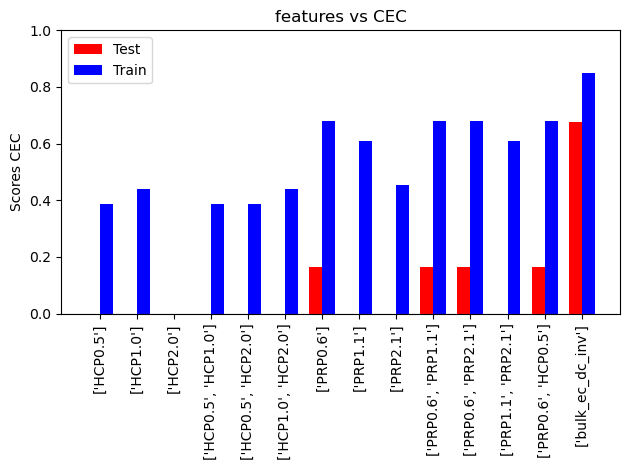

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -2.195 0.0 5.491 5.315 ['HCP0.5'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.666 0.438 5.191 3.929 ['HCP1.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -2.195 0.0 5.491 5.315 ['HCP2.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -2.195 0.0 5.491 5.315 ['HCP0.5', 'HCP1.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -2.195 0.0 5.491 5.315 ['HCP0.5', 'HCP2.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.666 0.438 5.191 3.929 ['HCP1.0', 'HCP2.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.599 0.583 4.082 3.327 ['PRP0.6'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_

<Figure size 640x480 with 0 Axes>

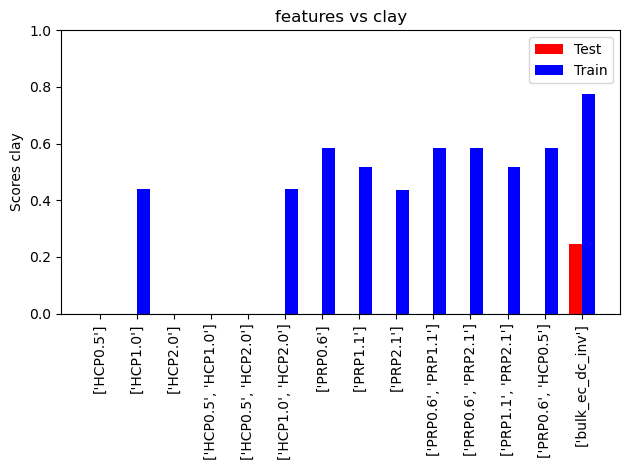

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['HCP0.5'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['HCP1.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['HCP2.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['HCP0.5', 'HCP1.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['HCP0.5', 'HCP2.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['HCP1.0', 'HCP2.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.493 0.0 0.048 0.046 ['PRP0.6'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train

<Figure size 640x480 with 0 Axes>

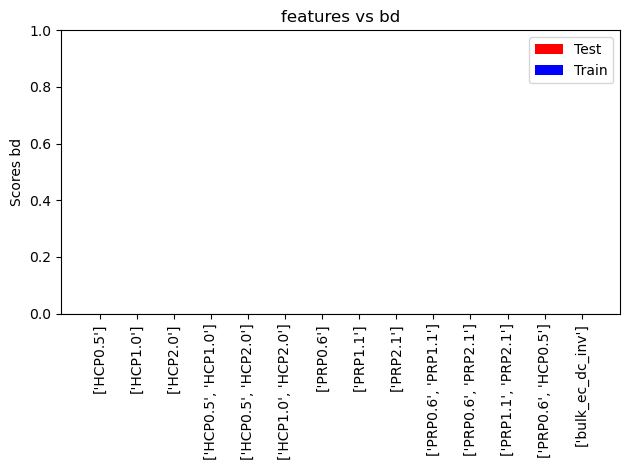

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.201 0.504 0.014 0.011 ['HCP0.5'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -0.528 0.487 0.015 0.011 ['HCP1.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.671 0.0 0.017 0.015 ['HCP2.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.201 0.504 0.014 0.011 ['HCP0.5', 'HCP1.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.201 0.504 0.014 0.011 ['HCP0.5', 'HCP2.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -0.528 0.487 0.015 0.011 ['HCP1.0', 'HCP2.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 0.348 0.715 0.01 0.008 ['PRP0.6'] ['w

<Figure size 640x480 with 0 Axes>

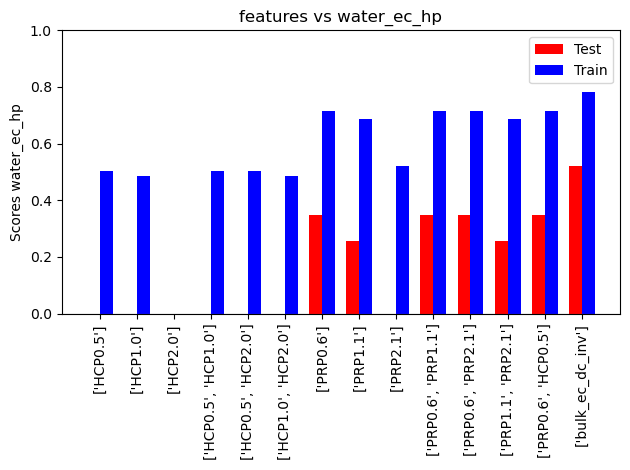

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.626 0.255 0.121 0.102 ['HCP0.5'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.718 0.0 0.127 0.119 ['HCP1.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.718 0.0 0.127 0.119 ['HCP2.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.626 0.255 0.121 0.102 ['HCP0.5', 'HCP1.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.626 0.255 0.121 0.102 ['HCP0.5', 'HCP2.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.718 0.0 0.127 0.119 ['HCP1.0', 'HCP2.0'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 0.004 0.47 0.097 0.086 ['PRP0.6'] ['vwc']
best_n, R2_test_pol, R2_train_pol, RMSE_test_po

<Figure size 640x480 with 0 Axes>

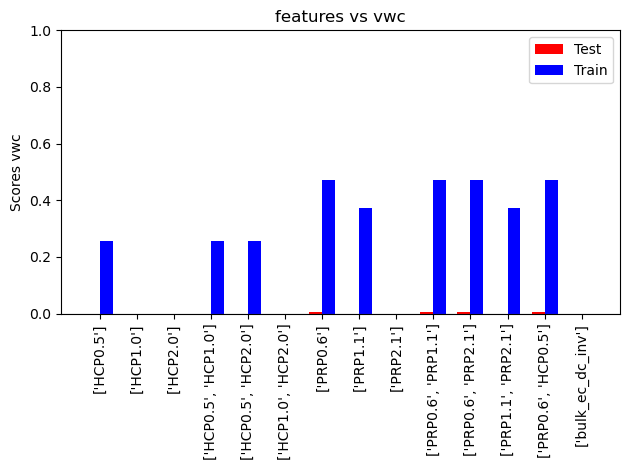

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -3.224 0.334 9.338 7.747 ['HCP0.5'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -3.143 0.0 9.926 9.577 ['HCP1.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -3.143 0.0 9.926 9.577 ['HCP2.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -3.224 0.334 9.338 7.747 ['HCP0.5', 'HCP1.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -3.224 0.334 9.338 7.747 ['HCP0.5', 'HCP2.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -3.143 0.0 9.926 9.577 ['HCP1.0', 'HCP2.0'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.478 0.767 6.446 4.472 ['PRP0.6'] ['CEC']
best_n, R2_test_pol, R2_train_pol, RMSE_test_

<Figure size 640x480 with 0 Axes>

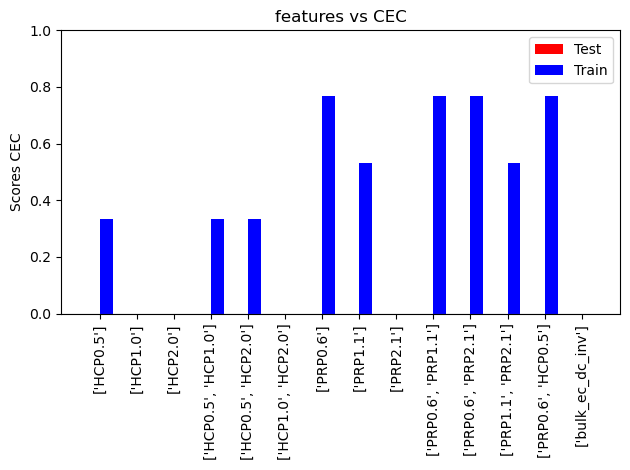

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -3.359 0.291 17.242 14.53 ['HCP0.5'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -3.532 0.0 17.738 17.38 ['HCP1.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -3.532 0.0 17.738 17.38 ['HCP2.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -3.359 0.291 17.242 14.53 ['HCP0.5', 'HCP1.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -3.359 0.291 17.242 14.53 ['HCP0.5', 'HCP2.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -3.532 0.0 17.738 17.38 ['HCP1.0', 'HCP2.0'] ['clay']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.988 0.729 12.397 8.751 ['PRP0.6'] ['clay']
best_n, R2_test_pol, R2_train_p

<Figure size 640x480 with 0 Axes>

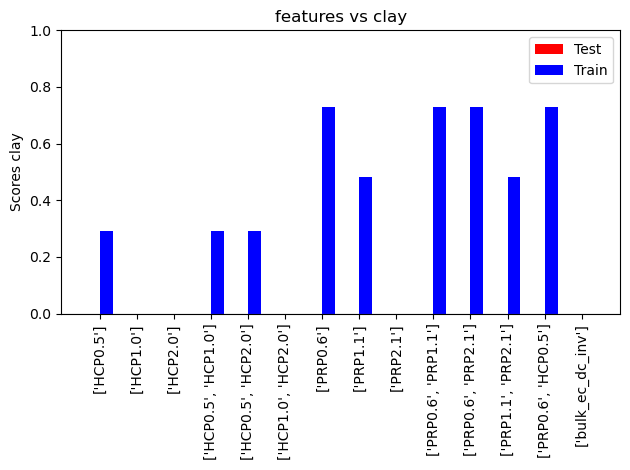

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.708 0.325 0.215 0.176 ['HCP0.5'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.74 0.0 0.234 0.217 ['HCP1.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.74 0.0 0.234 0.217 ['HCP2.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.708 0.325 0.215 0.176 ['HCP0.5', 'HCP1.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -0.708 0.325 0.215 0.176 ['HCP0.5', 'HCP2.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -0.74 0.0 0.234 0.217 ['HCP1.0', 'HCP2.0'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -0.024 0.668 0.158 0.121 ['PRP0.6'] ['bd']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_

<Figure size 640x480 with 0 Axes>

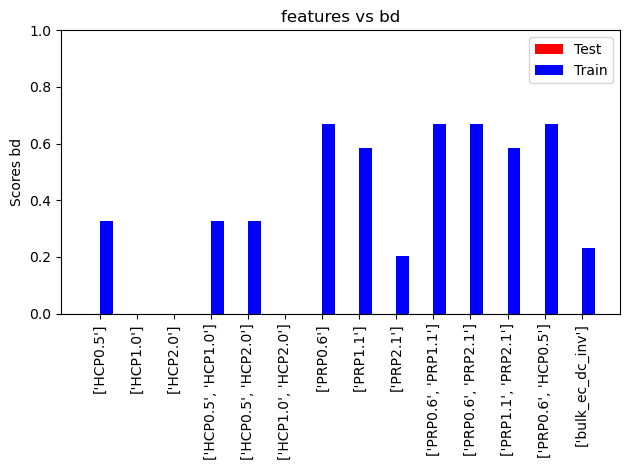

best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 3 -7.954 0.528 0.012 0.008 ['HCP0.5'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -2.479 0.256 0.013 0.01 ['HCP1.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 0 -1.868 0.0 0.013 0.012 ['HCP2.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 3 -7.954 0.528 0.012 0.008 ['HCP0.5', 'HCP1.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 3 -7.954 0.528 0.012 0.008 ['HCP0.5', 'HCP2.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 1 -2.479 0.256 0.013 0.01 ['HCP1.0', 'HCP2.0'] ['water_ec_hp']
best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target: 2 -1.602 0.584 0.01 0.007 ['PRP0.6'] ['wa

<Figure size 640x480 with 0 Axes>

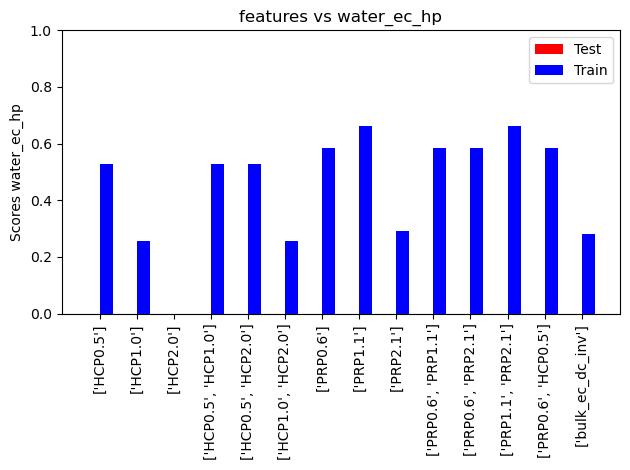

,Target,Best EC feature,R2,Best EC feature 10cm,R2 10cm,Best EC feature 50cm,R2 50cm,Best EC feature layered,R2 layered
0,vwc,bulk_ec_dc_inv,-0.06,HCP0.5,-0.525,PRP0.6,0.004,NaN,NaN
1,CEC,PRP0.6,0.039,bulk_ec_dc_inv,0.675,PRP0.6,-1.478,NaN,NaN
2,clay,bulk_ec_dc_inv,-0.094,bulk_ec_dc_inv,0.246,PRP1.1,-1.979,NaN,NaN
3,bd,PRP0.6,-0.012,HCP0.5,-0.493,PRP0.6,-0.024,NaN,NaN
4,water_ec_hp,bulk_ec_dc_inv,0.627,bulk_ec_dc_inv,0.522,PRP0.6,-1.602,NaN,NaN


<Figure size 640x480 with 0 Axes>

In [49]:
target_set = [
    ['vwc'],
    ['CEC'],
    ['clay'],
    ['bd'],
    ['water_ec_hp']
]

for depth in [10, 50]:
    i = 0
    for t in target_set:
        R2_test, R2_train = [], []
        target = ds_all[t[0]].values
        
        for feature_set in feature_sets:        
            best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol = stochastic_poly_layer(ds_all, feature_set, t, depth, iters=100)
            print('best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, target:', best_n, R2_test_pol, R2_train_pol, RMSE_test_pol, RMSE_train_pol, feature_set, t)
            R2_test.append(R2_test_pol)
            R2_train.append(R2_train_pol)

        print('R2_test', R2_test)
        best_index = R2_test.index(np.max(R2_test))
        R2_stochastic['Best EC feature '+str(depth)+'cm'][i] = feature_sets[best_index][0]
        R2_stochastic['Target'][i] = t[0]
        R2_stochastic['R2 '+str(depth)+'cm'][i] = R2_test[best_index]
        print('for predicting stochastically '+ t[0]+' the best predictor is:' +feature_sets[best_index][0])
        bars_plot(feature_sets, R2_test, R2_train, t)
        i+=1
R2_stochastic